In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from patrolling_env.graph_env import GraphPatrolEnv
from patrolling_agents.rl_agent_2 import PatrolAgent2

from util import moving_average
from util.simulator import play_episodes_graph as simulate

## 1 - Training the agent

In [15]:
genv = GraphPatrolEnv('map_a.adj', 3, reward_type='avg_idleness')
#genv = GraphPatrolEnv('map_a.adj', 3, reward_type='visited_idleness')
#genv = GraphPatrolEnv('map_a.adj', 3, reward_type='visited_quadr_idleness')

# obs.: a environment wrapper is instantiated inside the agent
#agent = PatrolAgent2(features='pidcq', learning_rate=0.0040, beta=0.05, n_step=3, beta_update=6, verbose=True, model='linear', shared_weights=True)
agent = PatrolAgent2(features='pidcq', learning_rate=0.0040, beta=0.05, n_step=3, beta_update=6, verbose=True, model='linear', shared_weights=False)

start_time = time()
rewards, cumul_rewards = agent.train(genv, 10_000)
print("Time elapsed (s):", time() - start_time)

Step 1000, mean of last 1000 rewards: -29.713
Step 2000, mean of last 1000 rewards: -21.957
Step 3000, mean of last 1000 rewards: -17.329
Step 4000, mean of last 1000 rewards: -14.906
Step 5000, mean of last 1000 rewards: -14.051
Step 6000, mean of last 1000 rewards: -12.589
Step 7000, mean of last 1000 rewards: -12.379
Step 8000, mean of last 1000 rewards: -12.025
Step 9000, mean of last 1000 rewards: -11.665
Step 10000, mean of last 1000 rewards: -11.133
Time elapsed (s): 48.53591871261597


In [16]:
# Pesos das features -- só para modelo linear e sem pesos compartilhados !
# Considerar as features na ordem em que foram passadas para o construtor
# ex.: features='npilcd' --> pesos representam NodeCount, PresenceCount, Idleness, LRTA*-Heuristic, ConstantStat (1.0 for valid neighbors), Degree

if agent.model == 'linear':
    if agent.shared_weights:
        print("Critic weights:", agent.critic.weights.view(-1).detach().numpy())
        print("Policy weights:", agent.policy.weights.view(-1).detach().numpy())
    else:
        for i in range(0,agent.num_agents):
            print(f"AGENT {i}")
            print(" - critic weights:", agent.critic.models[i].weights.view(-1).detach().numpy())
            print(" - policy weights:", agent.policy.models[i].weights.view(-1).detach().numpy())

AGENT 0
 - critic weights: [-1.0258442  -3.5560267   0.11127698 -0.09741217  0.5817335 ]
 - policy weights: [-0.35544023  3.3767061   0.2519801   1.1667888   0.6338928 ]
AGENT 1
 - critic weights: [-0.43393442 -0.9607405   0.12137198 -0.50778073  0.09685195]
 - policy weights: [-0.26419315  4.2542005   0.22796848  1.3837405   0.53336334]
AGENT 2
 - critic weights: [-0.3611387  -0.85046357  0.03780768 -0.38921577  0.20506954]
 - policy weights: [-0.7083135   4.1744037   0.34302464  1.3345519   0.67413193]


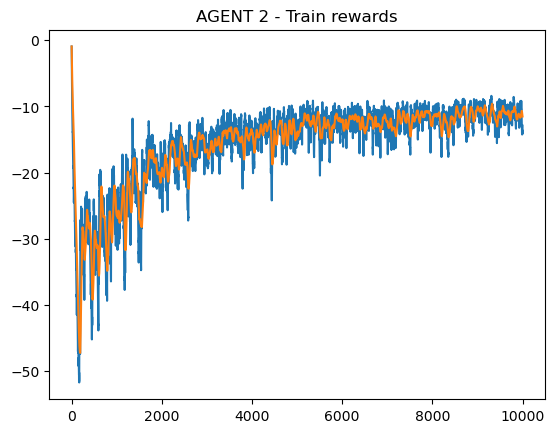

In [17]:
plt.plot(rewards)
plt.plot(moving_average(rewards, 50))
plt.title("AGENT 2 - Train rewards")
plt.show()

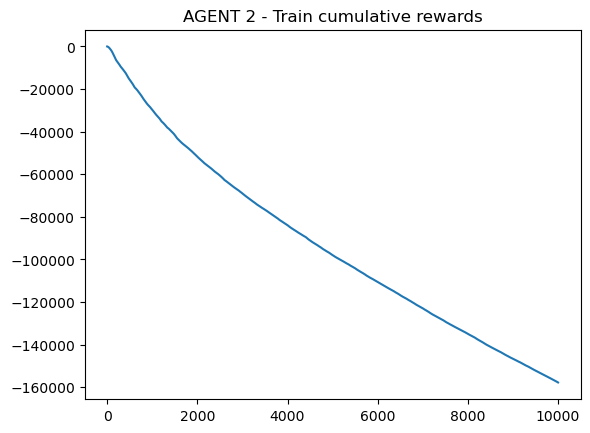

In [18]:
plt.plot(cumul_rewards)
plt.title("AGENT 2 - Train cumulative rewards")
plt.show()

## 2 - Simulating the trained agent

In [19]:
stats = simulate(agent.get_wrapper_env(), agent, max_steps=1_000)

Episode 1 steps: 1000 , reward: -11216.759999999995
Total Results: 
 => mean reward: -11216.759999999995, episodes: 1, steps: 1000


In [20]:
stats = np.asarray(stats)
stats

array([[27,  0, 26],
       [16, 48, 43],
       [28, 36, 41],
       ...,
       [26, 17, 39],
       [ 1, 24, 34],
       [43, 31, 46]])

## 3 - Data analysis of the simulation

In [21]:
import pandas as pd

### 3.1 - Visited nodes

In [22]:
# ids of the nodes visited by each agent
df = pd.DataFrame({'ag0': stats[:,0],'ag1': stats[:,1],'ag2': stats[:,2]})
df

,ag0,ag1,ag2
0,27,0,26
1,16,48,43
2,28,36,41
3,27,12,13
4,11,37,33
...,...,...,...
996,22,25,4
997,42,44,45
998,26,17,39
999,1,24,34


In [23]:
#df['ag0'].plot.hist(bins=50)

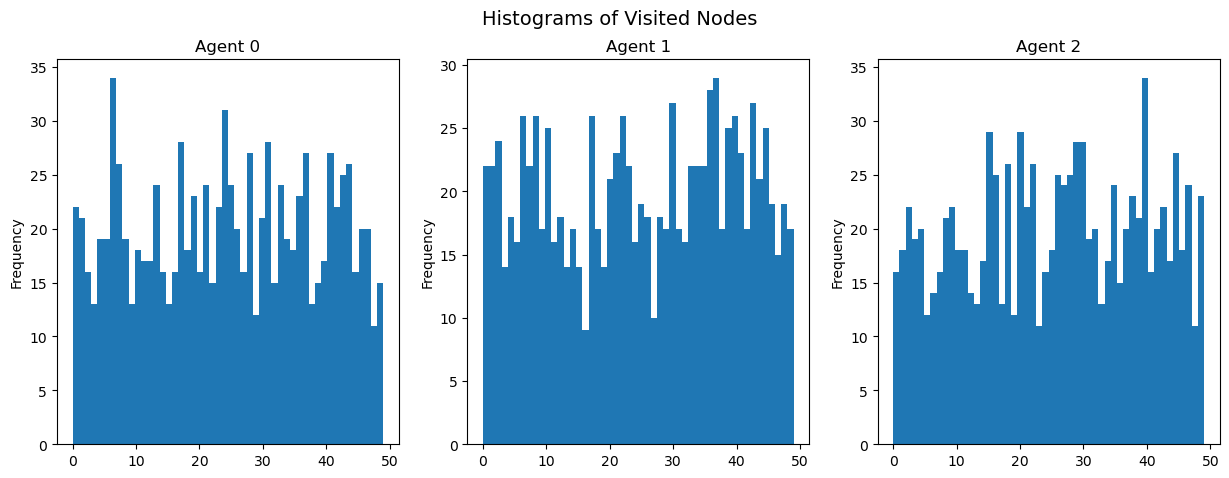

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 grid of subplots
for i in range(agent.num_agents):
    df[f'ag{i}'].plot.hist(ax=axes[i], bins=50, title=f'Agent {i}')

#plt.tight_layout()  # Ensures subplots do not overlap
plt.suptitle('Histograms of Visited Nodes', fontsize=14) ;

In [25]:
#df2 = pd.melt(df, var_name='agent', value_name='node_id')
#df2.plot.hist(by='agent', bins=50)

In [26]:
df_node = pd.DataFrame(index=range(0,50), data = {'ag0' : df['ag0'].value_counts(), 'ag1' : df['ag1'].value_counts(), 'ag2' : df['ag2'].value_counts()})
df_node.head(10)

,ag0,ag1,ag2
0,22,22,16
1,21,22,18
2,16,24,22
3,13,14,19
4,19,18,20
5,19,16,12
6,34,26,14
7,26,22,16
8,19,26,21
9,13,17,22


<Axes: title={'center': 'Total Visits per Node'}>

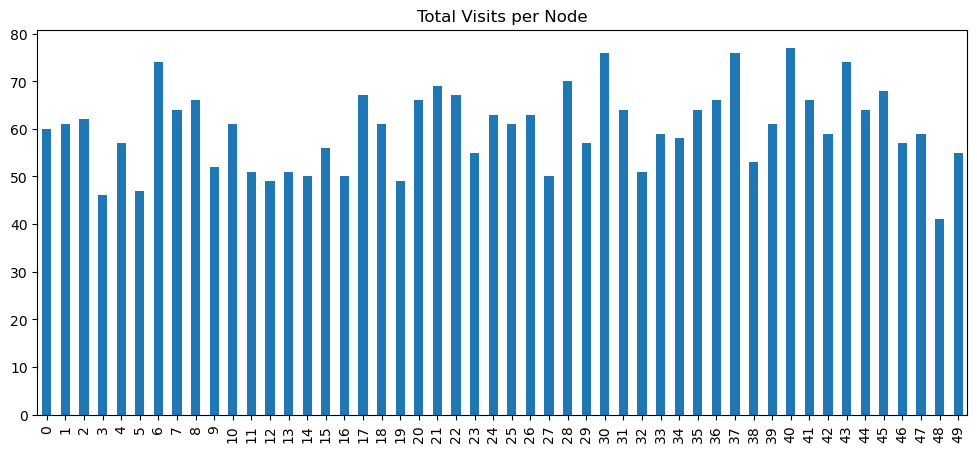

In [27]:
plt.figure(figsize=(12,5))
plt.title('Total Visits per Node')
df_node.sum(axis=1).plot.bar()